# 波形平滑处理Smoothing

    本节呢，主要介绍一下RTS-Smoothing的方法，他是Fixed-Interval-Smoothing这一类的一个比较常用、比较简便、比较高效的处理器，是由Rauch, Tung, and Striebel 他们设计而成的。此外，还有一类Fixed-Lag-Smoothing的通用方法，通常使用时，直接设置对象为FixedLagSmoother类，而代替KalmanFilter类的调用，在Fixed-Lag-Smoothing类中，相比下多了N这个变量，它表示平滑处理中采用N个将来的测量值来平滑处理当前的估计值。  
    
    In this section, we mainly introduce the RTS-Smoothing method. It is a commonly used, relatively simple and efficient processor such as Fixed-Interval-Smoothing. It is designed by Rauch, Tung, and Striebel. . In addition, there is a general method of a class of Fixed-Lag-Smoothing. When used normally, the object is set directly to the FixedLagSmoother class instead of the KalmanFilter class. In the Fixed-Lag-Smoothing class, there is more N than the variable, which means that N future measurements are used in the smoothing process to smooth the current estimate.

## 1、RTS-Smoothing Method

    我们知道，通常情况下，我们设计的滤波器初始状态时偏差都较大，随着测量的增多，滤波器的估计值逐渐向真实值收敛。因此，RTS方法设计的平滑处理器便默认最后一次状态估计准确，然后从最后一个状态开始，采用用后一点的状态来平滑处理前一点的状态的想法，依次向前，从而完成平滑处理。  
    
    We know that under normal circumstances, the deviation of the initial state of the filter we designed is large. As the measurement increases, the estimated value of the filter gradually converges to the true value. Therefore, the smoothing processor designed by the RTS method assumes that the last state estimation is accurate, and then starts from the last state, smoothing the state of the previous point with the state of the latter point, and going forward, thereby completing the smoothing process.

### - Algorithm：

>    Predict Step
>    
$$\begin{aligned}
\mathbf{P} &= \mathbf{FP}_k\mathbf{F}^\mathsf{T} + \mathbf{Q }
\end{aligned}$$
>
>    Update Step
>    
$$\begin{aligned}
\mathbf{K}_k &= \mathbf{P}_k\mathbf{F}^\mathsf{T} \hspace{2 mm}\mathbf{P}^{-1} \\
\mathbf{x}_k &= \mathbf{x}_k + \mathbf{K}_k(\mathbf{x}_{x+1} - \mathbf{FX}_k) \\
\mathbf{P}_k &= \mathbf{P}_k + \mathbf{K}_k(\mathbf{P}_{K+1} - \mathbf{P})\mathbf{K}_k^\mathsf{T}
\end{aligned}$$

```python
def rts_smoother(Xs, Ps, F, Q):
     """ Runs the Rauch-Tung-Striebal Kalman smoother on a set of means and covariances computed by a Kalman filter. 
     The usual input would come from the output of `KalmanFilter.batch_filter()`.

        Parameters:

        Xs : numpy.array
           array of the means (state variable x) of the output of a Kalmanfilter.

        Ps : numpy.array
            array of the covariances of the output of a kalman filter.

        Fs : list-like collection of numpy.array, optional
            State transition matrix of the Kalman filter at each time step.Optional, if not provided the filter's self.F will be used

        Qs : list-like collection of numpy.array, optional
            Process noise of the Kalman filter at each time step. Optional,if not provided the filter's self.Q will be used

        Returns:

        'x' : numpy.ndarray
           smoothed means

        'P' : numpy.ndarray
           smoothed state covariances

        'K' : numpy.ndarray
            smoother gain at each step
        """
    n, dim_x, _ = Xs.shape

    # smoother gain
    K = zeros((n,dim_x, dim_x))
    x, P = Xs.copy(), Ps.copy()

    for k in range(n-2,-1,-1):
        P_pred = dot(F, P[k]).dot(F.T) + Q

        K[k]  = dot(P[k], F.T).dot(inv(P_pred))
        x[k] += dot(K[k], x[k+1] - dot(F, x[k]))
        P[k] += dot(K[k], P[k+1] - P_pred).dot(K[k].T)
    return (x, P, K)
```
这个算法是线性KalmanFilter类下的rts_smoother方法。  
在EKF类和UKF类下同样也有类似的rts_smoother方法，不过奇怪的是，好像并不太支持受控情况下平滑处理，我们来看一下help()怎么说的：  

This algorithm is the rts_smoother method under the linear KalmanFilter class.  
There are similar rts_smoother methods in the EKF and UKF classes, but the strange thing is that it doesn't seem to support smoothing under controlled conditions. Let's see what help() says:

In [2]:
from filterpy.kalman import UnscentedKalmanFilter
help(UnscentedKalmanFilter.rts_smoother)

Help on function rts_smoother in module filterpy.kalman.UKF:

rts_smoother(self, Xs, Ps, Qs=None, dt=None)
    Runs the Rauch-Tung-Striebal Kalman smoother on a set of
    means and covariances computed by the UKF. The usual input
    would come from the output of `batch_filter()`.
    
    Parameters
    ----------
    
    Xs : numpy.array
       array of the means (state variable x) of the output of a Kalman
       filter.
    
    Ps : numpy.array
        array of the covariances of the output of a kalman filter.
    
    Qs: list-like collection of numpy.array, optional
        Process noise of the Kalman filter at each time step. Optional,
        if not provided the filter's self.Q will be used
    
    dt : optional, float or array-like of float
        If provided, specifies the time step of each step of the filter.
        If float, then the same time step is used for all steps. If
        an array, then each element k contains the time  at step k.
        Units are seconds.


我们可以发现，`rts_smoother(self, Xs, Ps, Qs=None, dt=None)`方法参数中并没有控制变量u的出现，但是在方法中有这样一句话：  
We can see that there is no control variable u in the `rts_smoother(self, Xs, Ps, Qs=None, dt=None)` method parameter, but there is such a sentence in the method:  
```python
for i in range(num_sigmas):
    sigmas_f[i] = self.fx(sigmas[i], dt[k])
```
其中，方法fx()是需要有控制量u的输入的，因为它在完成$\bar x = Fx + Bu$ 的过程，因此，我在怀疑这个方法是不是有缺失受控部分的平滑处理的能力，这一方面我没有细究，有兴趣的同学可以继续探索。  

Among them, the method fx() is required to have the input of the control quantity u because it is in the process of completing $\bar x = Fx + Bu$. Therefore, I am doubting whether this method has the ability to smooth out the controlled part. I have not studied it in this way. Interested students can continue to explore.  

接下来我们看一个例题，这是一个不具有控制量输入的滤波器，所以他的平滑处理可以实现，但是如果有就出了问题，可以参考[这里的例题](http://nbviewer.jupyter.org/github/w407022008/All-of-Notes/blob/master/Kalman-Bayesian-Filter-Notes/04%20Unscented-Kalman-Filter-Notes---Multi-position-Sensor-Fusion.ipynb)：

Next, let's look at an example. This is a filter that does not have a control input, so his smoothing can be achieved. But if there is input, there will be problems, you can refer to this [example]((http://nbviewer.jupyter.org/github/w407022008/All-of-Notes/blob/master/Kalman-Bayesian-Filter-Notes/04%20Unscented-Kalman-Filter-Notes---Multi-position-Sensor-Fusion.ipynb).

In [1]:
from numpy import math

# 生成状态变量测量方程
def h_radar(x):
    """
        measurement function for sensor fussion
    """
    dx = x[0] - h_radar.radar_pos[0]
    dy = x[2] - h_radar.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dy**2)
    elevation_angle = math.atan2(dy, dx)  
    return slant_range, elevation_angle, x[1], x[3]

# 生成状态变量传递方程
def f_radar(x, dt):
    """
        state transition function with dim_x=4
    """
    F = np.array([[1, dt, 0, 0],
                  [0,  1, 0, 0],
                  [0,  0, 1, dt],
                  [0, 0, 0, 1]], dtype=float)
    return np.dot(F, x)


In [2]:
from numpy.linalg import norm

## 目标位置测量值受测量精度产生的不准确
class RadarStation(object):
    
    def __init__(self, radar_pos, range_std, elevation_angle_std):
        """
            radar_pos , range_std , elevation_angle_std
        """
        self.pos = np.asarray(radar_pos)       
        self.range_std = range_std
        self.elevation_angle_std = elevation_angle_std

    def noise_reading(self, ac_pos):
        """
            input: ac_pos
            output: slant distance , slope  with noise
        """
        diff = np.subtract(ac_pos, self.pos)    
        rng = norm(diff) + randn() * self.range_std
        ang = math.atan2(diff[1], diff[0]) + randn() * self.elevation_angle_std 
        #print((rng*math.cos(ang),rng*math.sin(ang)))
        return rng, ang       

## 实际位置受实际速度的不稳定造成的不准确
class ACSim(object):
    def __init__(self, ac_pos, ac_vel, vel_std):
        self.pos = np.asarray(ac_pos, dtype=float)
        self.vel = np.asarray(ac_vel, dtype=float)
        self.vel_std = vel_std        
        
    def update(self, dt):
        self.vel += randn() * self.vel_std
        self.pos += self.vel * dt      
        return self.pos, self.vel
    
    

Actual altitude: 2518.3
UKF altitude   : 2524.8


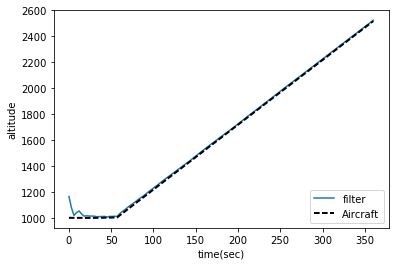

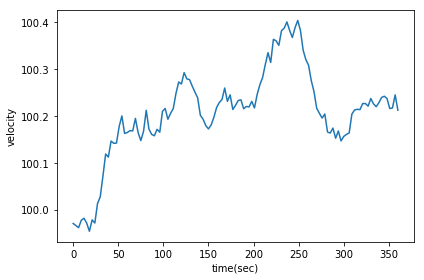

Difference in position in meters:
	 [-0.0424  0.2092 -0.1126 -0.456  -0.1117]


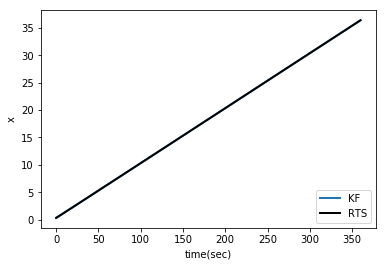

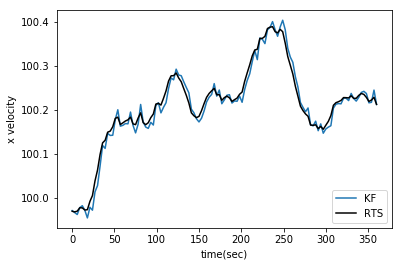

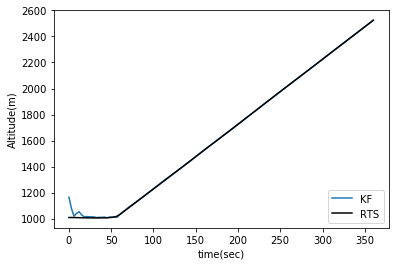

In [3]:
#format the book
%matplotlib inline
from __future__ import division, print_function

import math
import numpy as np
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise
from kf_book.ukf_internal import plot_altitude, plot_radar
from numpy.random import random,randn
import matplotlib.pyplot as plt
import kf_book.ukf_internal as ukf_internal


dt = 3. # 每3秒一次
range_std = 500 # meters
elevation_angle_std = math.radians(.5)
ac_pos = (0., 1000.)
ac_vel = (100., 0.)
vel_std = .02
radar_pos = (0., 0.)
h_radar.radar_pos = radar_pos


points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=-1.)             # 建立MSSP模型，生成sigma点集points
ukf=UKF(4, 4, dt, fx=f_radar, hx=h_radar, points=points)                       # 建立UKF模型，生成UKF对象ukf
# 设置UKF参数
ukf.Q[0:2, 0:2] = Q_discrete_white_noise(dim=2, dt=dt, var=0.1)
ukf.Q[2:4, 2:4] = Q_discrete_white_noise(dim=2, dt=dt, var=0.1)
ukf.R = np.diag([range_std**2, elevation_angle_std**2, vel_std**2, vel_std**2])
ukf.x = np.array([0., 90., 1100., 0.])
ukf.P = np.diag([300**2, 3**2, 150**2, 3**2])


np.random.seed(200)
ac = ACSim(ac_pos, ac_vel, vel_std)                                            # 生成实际位置坐标对象ac
radar = RadarStation(radar_pos, range_std, elevation_angle_std)                # 生成测量位置坐标对象radar

time = np.arange(0, 360 + dt, dt)
xs, ys, zs, covs= [], [], [], []

for t in time:
    if t >= 60:
        ac.vel[1] = 300/60 # 300 meters/minute climb
    ac.update(dt)
    r = radar.noise_reading(ac.pos)
    zs.append([r[0], r[1], ac.vel[0], ac.vel[1]])                              # 生成测量变量列表，通常有sensor直接获取
                                        # 此处采用SensorsFussion。其中，r为RadarStation测量到的方位坐标值；ac.vel为其他sensor测量的速度值。
    ukf.predict()                       # ukf对象进行先验估计，此处不存在控制量u
    ukf.update(zs[int(t/dt)])           # ukf对象进行后验估计
    ys.append(ac.pos[1])
    xs.append(ukf.x)
    covs.append(ukf.P)
    

plot_altitude(xs, time, ys)
print('Actual altitude: {:.1f}'.format(ac.pos[1]))
print('UKF altitude   : {:.1f}'.format(xs[-1][2]))

xs = np.asarray(xs)
plot_radar(xs, time, plot_x=False, plot_vel=True, plot_alt=False)

#Xs, covs, _, _ = ukf.batch_filter(zs)
Means, P, K = ukf.rts_smoother(xs, covs)  #### RTS_smoother,,,Rauch, Tung, and Striebel.,,,means,covariances,kalman gain
ukf_internal.plot_rts_output(xs, Means, time)


## 2、Fixed-Lag-Smoothing Method

我们再来看一下Fixed-Lag-Smoothing方法，方法思想前面已经介绍过了，现在给一个例题看看就好：  

Let's take a look at the Fixed-Lag-Smoothing method. The method idea has already been introduced. Now let's take a look at an example:

standard deviation fixed-lag: 1.02205177146
standard deviation kalman: 1.71535099969


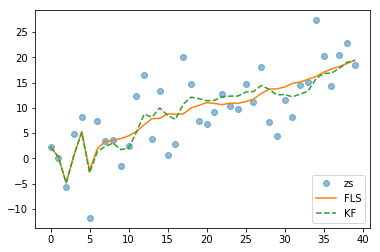

In [6]:
from filterpy.kalman import FixedLagSmoother, KalmanFilter
import numpy.random as random

## FixedLagSmoother
fls = FixedLagSmoother(dim_x=2, dim_z=1, N=8)   #由N个向后测量量来平滑当前的估计值

fls.x = np.array([0., .5])
fls.F = np.array([[1.,1.],
                  [0.,1.]])
fls.H = np.array([[1.,0.]])
fls.P *= 200
fls.R *= 5.
fls.Q *= 0.001

## KalmanFilter
kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = np.array([0., .5])
kf.F = np.array([[1.,1.],
                 [0.,1.]])
kf.H = np.array([[1.,0.]])
kf.P *= 200
kf.R *= 5.
kf.Q *= 0.001


nom =  np.array([t/2. for t in range (0, 40)])
zs = np.array([t + random.randn()*5.1 for t in nom])

for z in zs:
    fls.smooth(z)
    
kf_x, _, _, _ = kf.batch_filter(zs)
x_smooth = np.array(fls.xSmooth)[:, 0]

fls_res = abs(x_smooth - nom)
kf_res = abs(kf_x[:, 0] - nom)

plt.plot(zs,'o', alpha=0.5, marker='o', label='zs')
plt.plot(x_smooth, label='FLS')
plt.plot(kf_x[:, 0], label='KF', ls='--')
plt.legend(loc=4)

print('standard deviation fixed-lag:', np.mean(fls_res))
print('standard deviation kalman:', np.mean(kf_res))
